<a href="https://colab.research.google.com/github/helloitsdaksh/Tensorflow_colab/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

We've seen the power of tranfer learning feature extraction and fine-tuning, now its time to scale up to all of the classes of Food101(101 total classes of food)

Our goal is to **beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data**


## What we're going to cover

We're going to go through the follow with TensorFlow:

- Downloading and preparing 10% of the Food101 data (10% of training data)
- Training a feature extraction transfer learning model on 10% of the Food101 training data
- Fine-tuning our feature extraction model
- Saving and loaded our trained model
- Evaluating the performance of our Food Vision model trained on 10% of the training data
  - Finding our model's most wrong predictions
- Making predictions with our Food Vision model on custom images of food

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Creating helper functions:

In [1]:
!wget https://raw.githubusercontent.com/helloitsdaksh/Tensorflow_colab/main/Extras/helper_functions.py

--2021-09-20 20:47:07--  https://raw.githubusercontent.com/helloitsdaksh/Tensorflow_colab/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12617 (12K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  12.32K  --.-KB/s    in 0s      

2021-09-20 20:47:07 (49.0 MB/s) - ‘helper_functions.py’ saved [12617/12617]



In [2]:
# import series of helper functions for our notebook
from helper_functions import *

In [ ]:
!nvidia-smi

Sun Sep 19 18:04:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.

In [3]:
## Downloading and Preprocessing the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 
unzip_data("101_food_classes_10_percent.zip")

# Creating the directories
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2021-09-20 20:47:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   177MB/s    in 8.5s    

2021-09-20 20:47:18 (181 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bruschetta'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in

In [4]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE,
                                                                                batch_size = 32) #default
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


Wonderful! It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images). 


## Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:
* A [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
* Data augmentation built right into the model
* A headless (no top layers) [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) architecture from `tf.keras.applications` as our base model
* A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
* Categorical crossentropy as the loss function since we're dealing with more than two classes
* The Adam optimizer with the default settings
* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

It seems like a lot but these are all things we've covered before in the [Transfer Learning in TensorFlow Part 2: Fine-tuning notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb).

Let's start by creating the `ModelCheckpoint` callback. 

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [ ]:
# Create data augmentation layer to incoporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
    preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
    preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
    preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
    preprocessing.RandomZoom(0.2), # randomly zoom into an image
    # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

Beautiful! We'll be able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a `Dense` layer.

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False,)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer") (x)
outputs = layers.Dense(101, activation="softmax", name = "output_layer") (x)
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Get a summary of model we created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# compile
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15*len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 153s 485ms/step - loss: 3.4592 - accuracy: 0.2573 - val_loss: 2.6905 - val_accuracy: 0.3962
Epoch 2/5
237/237 [==============================] - 95s 399ms/step - loss: 2.3510 - accuracy: 0.4613 - val_loss: 2.2528 - val_accuracy: 0.4653
Epoch 3/5
237/237 [==============================] - 83s 347ms/step - loss: 1.9753 - accuracy: 0.5311 - val_loss: 2.0492 - val_accuracy: 0.5005
Epoch 4/5
237/237 [==============================] - 78s 326ms/step - loss: 1.7705 - accuracy: 0.5674 - val_loss: 2.0296 - val_accuracy: 0.4815
Epoch 5/5
237/237 [==============================] - 78s 327ms/step - loss: 1.6019 - accuracy: 0.6012 - val_loss: 1.9670 - val_accuracy: 0.4905


In [ ]:
# Evaluate model 
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 101s 128ms/step - loss: 1.7329 - accuracy: 0.5438


[1.7328717708587646, 0.5438019633293152]

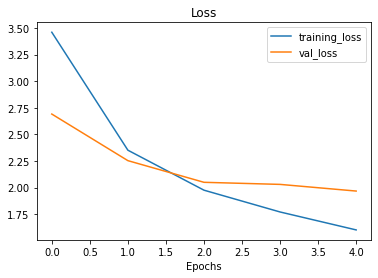

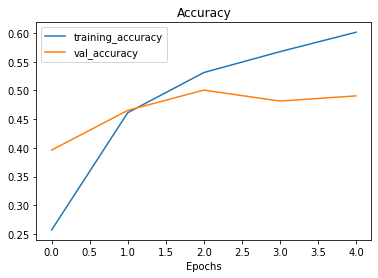

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

### Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the `ModelCheckpoint` callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its `trainable` attribute to `True`, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [ ]:
# Check which layers are trainable
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

Excellent! Time to fine-tune our model.

Another 5 epochs should be enough to see whether any benefits come about (though we could always try more).

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [ ]:
fine_tune_epochs = 10

# Refit the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                            epochs = fine_tune_epochs,
                                            validation_data = test_data,
                                            validation_steps = int(0.15*len(test_data)),
                                            initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 85s 321ms/step - loss: 1.3653 - accuracy: 0.6455 - val_loss: 1.9683 - val_accuracy: 0.4910
Epoch 6/10
237/237 [==============================] - 68s 285ms/step - loss: 1.2257 - accuracy: 0.6788 - val_loss: 1.9165 - val_accuracy: 0.5079
Epoch 7/10
237/237 [==============================] - 67s 281ms/step - loss: 1.1559 - accuracy: 0.6919 - val_loss: 1.8967 - val_accuracy: 0.5098
Epoch 8/10
237/237 [==============================] - 67s 282ms/step - loss: 1.0661 - accuracy: 0.7184 - val_loss: 1.9223 - val_accuracy: 0.5085
Epoch 9/10
237/237 [==============================] - 64s 270ms/step - loss: 1.0301 - accuracy: 0.7271 - val_loss: 1.9145 - val_accuracy: 0.5124
Epoch 10/10
237/237 [==============================] - 65s 273ms/step - loss: 0.9559 - accuracy: 0.7432 - val_loss: 1.9192 - val_accuracy: 0.5106


In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 101s 128ms/step - loss: 1.6267 - accuracy: 0.5745


[1.6267426013946533, 0.5744554400444031]

5
11
[0.2572937309741974, 0.4612541198730469, 0.5310891270637512, 0.5673927664756775, 0.6011881232261658, 0.6455445289611816, 0.6788119077682495, 0.6918811798095703, 0.7184158563613892, 0.7271286845207214, 0.7432343363761902]


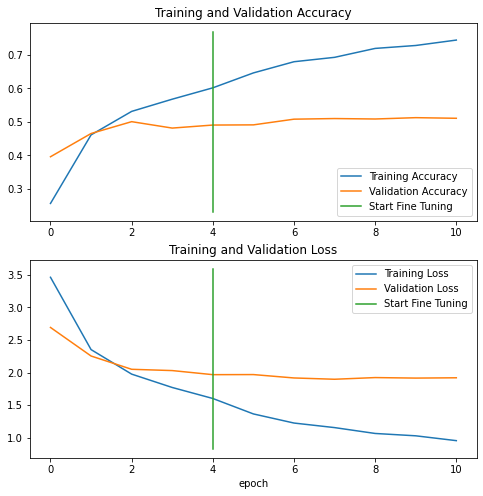

In [ ]:
# Let's compare the history
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit. 

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on [ImageNet](http://www.image-net.org/index) which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

In [ ]:
 # Save model to drive so it can be used later 
 model.save("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Evaluating the performance of the big dog model across all different classes

We've got a trained and saved model which according to the evaluation metrics we've used is performing fairly well.

But metrics schmetrics, let's dive a little deeper into our model's performance and get some visualizations going.

To do so, we'll load in the saved model and use it to make some predictions on the test dataset.

> 🔑 **Note:** Evaluating a machine learning model is as important as training one. Metrics can be deceiving. You should always visualize your model's performance on unseen data to make sure you aren't being fooled good looking training numbers.

In [5]:
import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

--2021-09-20 20:48:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   153MB/s    in 0.3s    

2021-09-20 20:48:13 (153 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [6]:
loaded_model_results  = model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 135s 130ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

### Making predictions with our trained model

To evaluate our trained model, we need to make some predictions with it and then compare those predictions to the test dataset.

Because the model has never seen the test dataset, this should give us an indication of how the model will perform in the real world on data similar to what it has been trained on.

To make predictions with our trained model, we can use the `predict()` method passing it the test data.

Since our data is multi-class, doing this will return a prediction probably tensor for each sample.

In other words, every time the trained model see's an image it will compare it to all of the patterns it learned during training and return an output for every class (all 101 of them) of how likely the image is to be that class.

In [7]:
# Make prediction with model
pred_probs = model.predict(test_data,verbose=1) # set verbosity to how long is left

790/790 [==============================] - 89s 110ms/step


In [8]:
# How many predictions are there?
len(pred_probs)

25250

In [9]:
# What's the shape of oour prediction
pred_probs.shape

(25250, 101)

In [10]:
# How do they look
pred_probs[1], pred_probs[1].shape

(array([9.64016795e-01, 1.37530887e-09, 8.47799762e-04, 1.88828353e-09,
        1.18346314e-11, 3.31066535e-10, 4.18404367e-10, 9.58344775e-12,
        1.00226941e-06, 8.57337223e-09, 6.17982536e-08, 9.12294862e-09,
        4.52113426e-07, 5.87327786e-09, 1.98824666e-04, 1.23728061e-09,
        4.83641852e-05, 4.17016156e-04, 3.56016199e-06, 1.60835248e-06,
        4.42118919e-09, 5.04211275e-05, 2.97712795e-05, 1.75283743e-09,
        7.18615411e-05, 2.86405633e-09, 9.98413441e-09, 1.73569497e-08,
        5.18879739e-09, 1.80488729e-04, 2.33668196e-10, 6.81474654e-09,
        5.05587413e-05, 1.42946215e-13, 1.22202066e-11, 2.25315002e-08,
        5.05355019e-05, 1.16543653e-09, 1.24836149e-07, 3.76283076e-08,
        1.78725756e-07, 5.60988781e-07, 2.59894800e-10, 1.05898679e-09,
        2.03683126e-10, 5.18307272e-12, 4.60146803e-05, 8.22260802e-07,
        9.59204244e-12, 3.18258060e-07, 1.91016326e-07, 1.43779399e-09,
        2.32744260e-05, 5.53362201e-09, 1.74098486e-10, 2.534245

In [11]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 1.

As we discussed before, for each image tensor we pass to our model, because of the number of output neurons and activation function in the last layer (`layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax"`), it outputs a prediction probability between 0 and 1 for all each of the 101 classes.

And the index of the highest prediction probability can be considered what the model thinks is the most likely label. Similarly, the lower prediction probaiblity value, the less the model thinks that the target image is that specific class.

> 🔑 **Note:** Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1). E.g. `pred_probs[0].sum() = 1`.

We can find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [12]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [13]:
len(pred_classes)

25250

Beautiful! We've now got the predicted class index for each of the samples in our test dataset.

We'll be able to compare these to the test dataset labels to further evaluate our model.

To get the test dataset labels we can unravel our `test_data` object (which is in the form of a `tf.data.Dataset`) using the [`unbatch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#unbatch) method.

Doing this will give us access to the images and labels in the test dataset. Since the labels are in one-hot encoded format, we'll take use the `argmax()` method to return the index of the label.

> 🔑 **Note:** This unravelling is why we `shuffle=False` when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [14]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [15]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Nice! Since `test_data` isn't shuffled, the `y_labels` array comes back in the same order as the `pred_classes` array.


The final check is to see how many labels we've got.

In [16]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

25250

### Evaluating our models predictions

A very simple evaluation is to use Scikit-Learn's [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function which compares truth labels to predicted labels and returns an accuracy score.

If we've created our `y_labels` and `pred_classes` arrays correctly, this should return the same accuracy value (or at least very close) as the `evaluate()` method we used earlier.

In [17]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6077623762376237

In [18]:
# Does this metric come close to our model's evaluate results
import numpy as np
print(f"Close? {np.isclose(loaded_model_results[1], sklearn_accuracy)} | Difference: {loaded_model_results[1] - sklearn_accuracy}")

Close? True | Difference: 2.0097978059574473e-08


Okay, it looks like our `pred_classes` array and `y_labels` arrays are in the right orders.

How about we get a little bit more visual with a confusion matrix?

To do so, we'll use our `make_confusion_matrix` function we created in a previous notebook.

In [19]:
# We'll import our make_confusion_matrix function from https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py 
# But if you run it out of the box, it doesn't really work for 101 classes...
# the cell below adds a little functionality to make it readable.

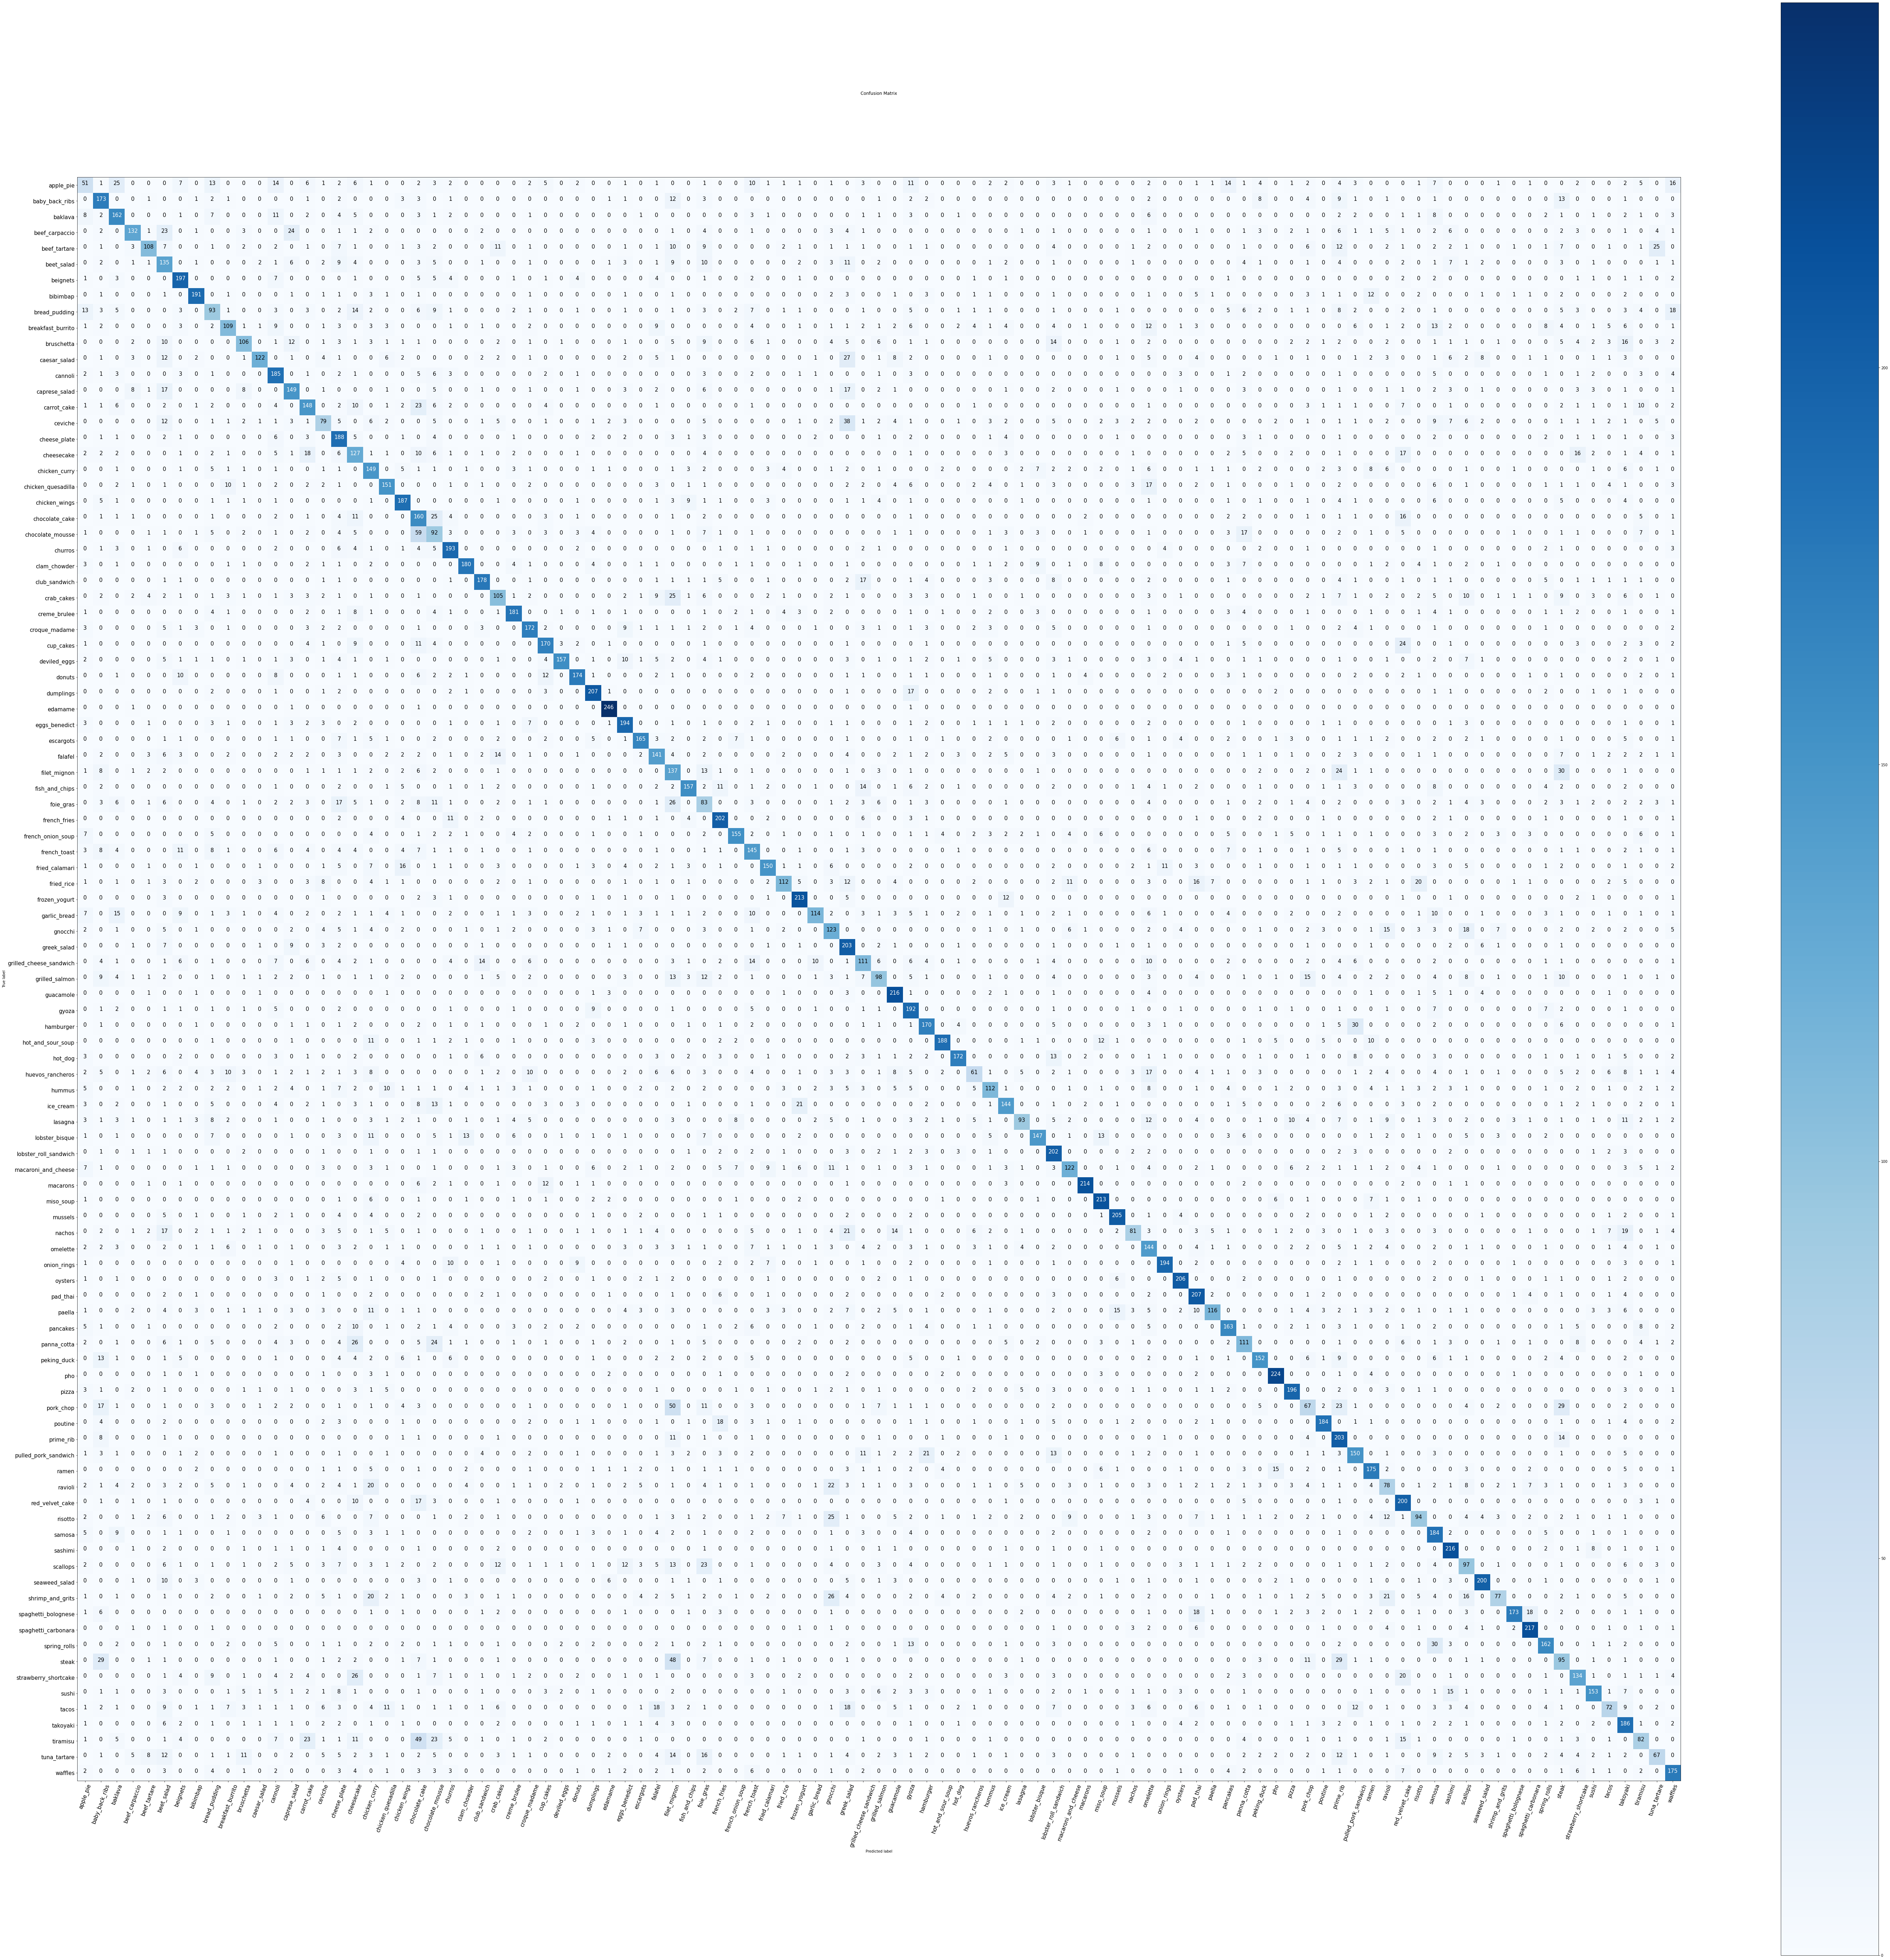

In [20]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100))

In [21]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

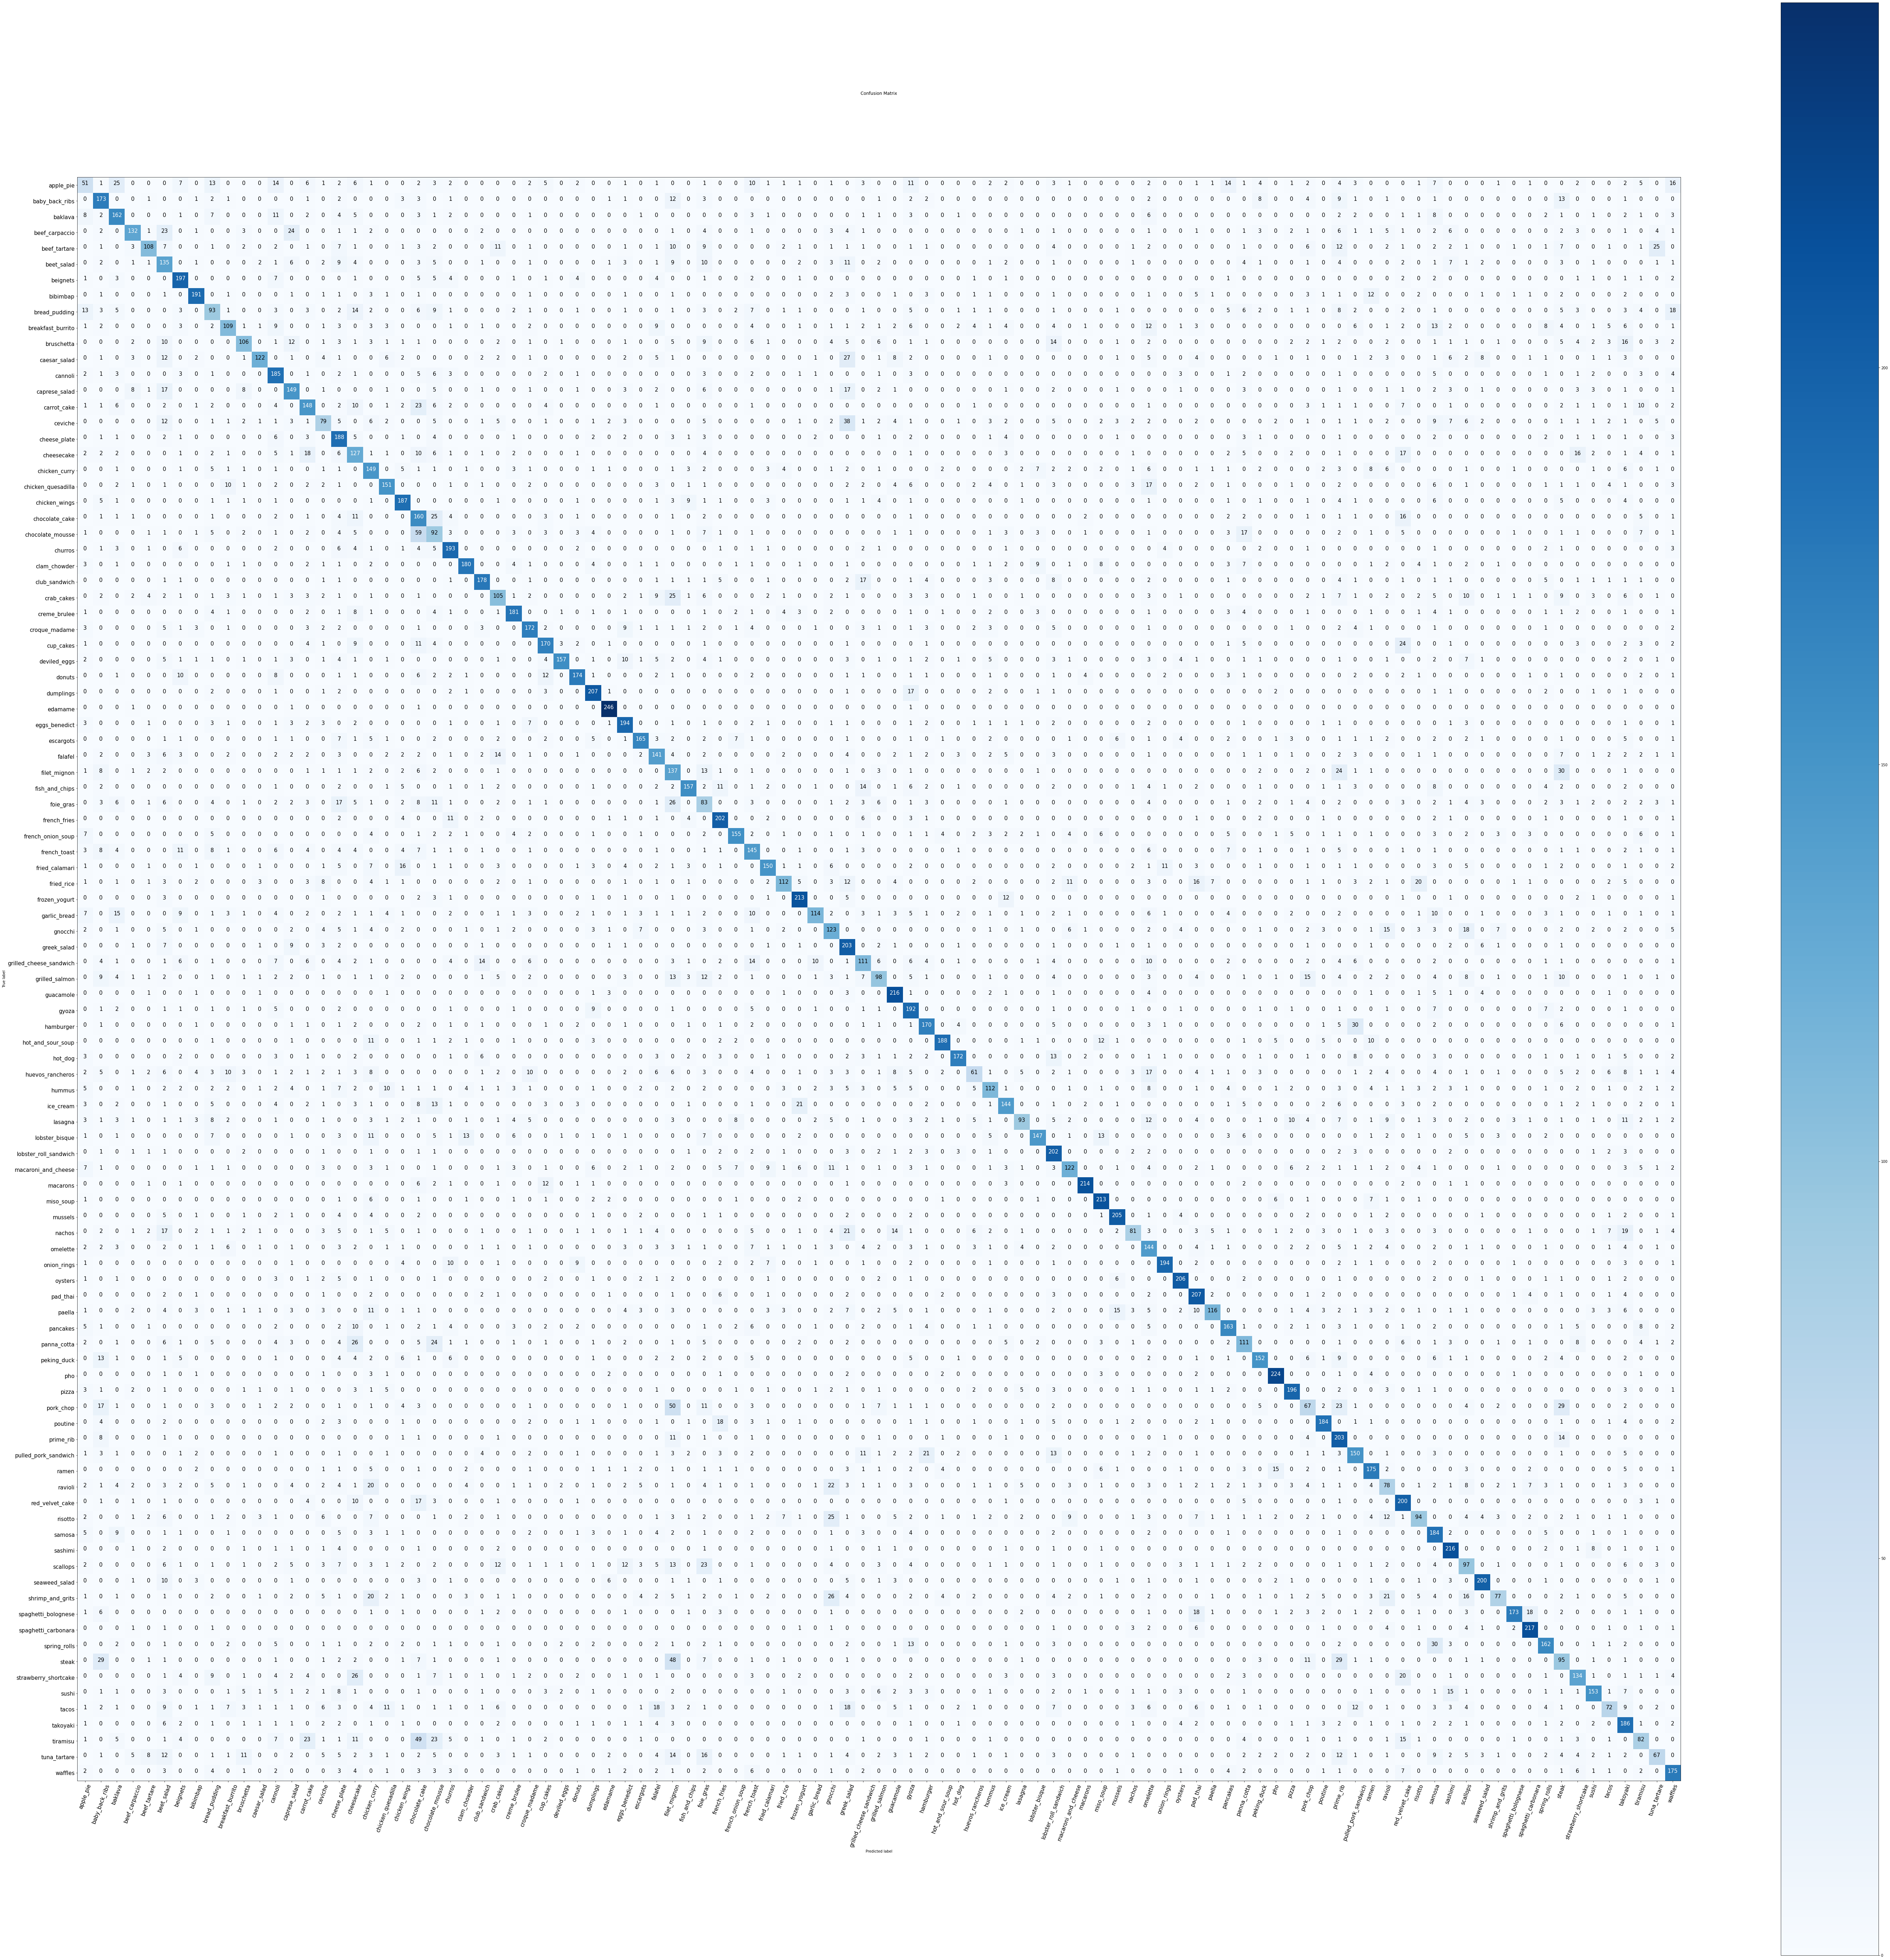

In [22]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100))

Woah! Now that's a big confusion matrix. It may look a little daunting at first but after zooming in a little, we can see how it gives us insight into which classes its getting "confused" on.

The good news is, the majority of the predictions are right down the top left to bottom right diagonal, meaning they're correct.

It looks like the model gets most confused on classes which look visualually similar, such as predicting `filet_mignon` for instances of `pork_chop` and `chocolate_cake` for instances of `tiramisu`.

Since we're working on a classification problem, we can further evaluate our model's predictions using Scikit-Learn's [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function.



In [23]:
## Let's keep the evaluate on other metrics 
from sklearn.metrics import classification_report
report = classification_report(y_labels,pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The `classification_report()` outputs the precision, recall and f1-score's per class.

A reminder:
* **Precision** - Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).
* **Recall** - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.
* **F1 score** - Combines precision and recall into one metric. 1 is best, 0 is worst.

The above output is helpful but with so many classes, it's a bit hard to understand.

Let's see if we make it easier with the help of a visualization.

First, we'll get the output of `classification_report()` as a dictionary by setting `output_dict=True`.

In [24]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Alright, there's still a fair few values here, how about we narrow down? 

Since the f1-score combines precision and recall in one metric, let's focus on that.

To extract it, we'll create an empty dictionary called `class_f1_scores` and then loop through each item in `classification_report_dict`, appending the class name and f1-score as the key, value pairs in `class_f1_scores`.

In [25]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[test_data.class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [26]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


In [27]:
import matplotlib.pyplot as plt
def plot_f1_scores(data_in_dataframe):
  fig, ax = plt.subplots(figsize=(12, 25))
  scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
  ax.set_yticks(range(len(f1_scores)))
  ax.set_yticklabels(list(f1_scores["class_name"]))
  ax.set_xlabel("f1-score")
  ax.set_title("F1-Scores for 10 Different Classes")
  ax.invert_yaxis(); # reverse the order

  def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
    """
    Attach a text label above each bar displaying its height (it's value).
    """
    for rect in rects:
      width = rect.get_width()
      ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
              f"{width:.2f}",
              ha='center', va='bottom')

  autolabel(scores)

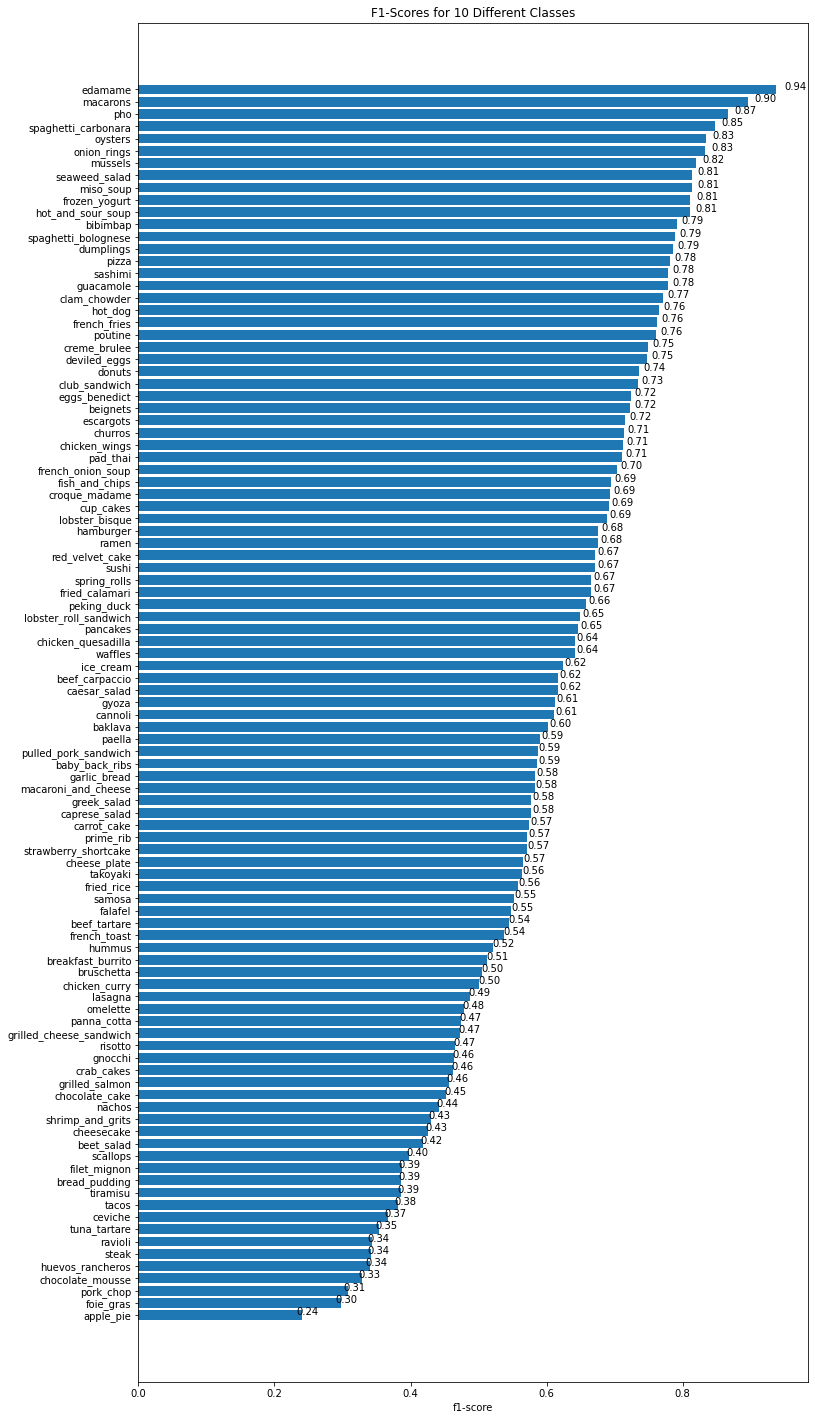

In [28]:
plot_f1_scores(f1_scores)

### Visualizing predictions on test images

Time for the real test. Visualizing predictions on actual images. You can look at all the metrics you want but until you've visualized some predictions, you won't really know how your model is performing.

As it stands, our model can't just predict on any image of our choice. The image first has to be loaded into a tensor.

So to begin predicting on any given image, we'll create a function to load an image into a tensor.

Specifically, it'll:
* Read in a target image filepath using [`tf.io.read_file()`](https://www.tensorflow.org/api_docs/python/tf/io/read_file).
* Turn the image into a `Tensor` using [`tf.io.decode_image()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_image).
* Resize the image to be the same size as the images our model has been trained on (224 x 224) using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize).
* Scale the image to get all the pixel values between 0 & 1 if necessary.

In [43]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  image = tf.io.read_file(filename)
  image = tf.io.decode_image(image, channels =3)

  image = tf.image.resize(image,[img_shape,img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return image/255.
  else:
    return image

Image loading and preprocessing function ready.

Now let's write some code to: 

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

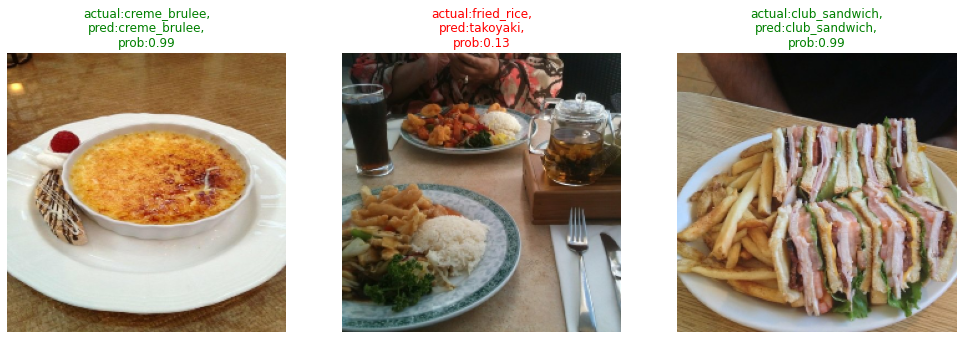

In [51]:
# Make prediction on series of random images
import os 
import random
plt.figure(figsize= (17,10))

for i in range(3):
  # choose random images from random classes
  class_name = random.choice(test_data.class_names)
  image_file = random.choice(os.listdir(test_dir + "/" + class_name))
  file_path = test_dir + "/" + class_name + "/" + image_file

  # Load the image and make predictions
  img = load_and_prep_image(file_path,scale = False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = test_data.class_names[pred_prob.argmax()]
  
  # Plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    color = "g"
  else:
    color = "r"
  plt.title(f"actual:{class_name},\npred:{pred_class},\nprob:{pred_prob.max():.2f}",c = color)
  plt.axis(False)